# Introdução à Recuperação de Informações
# Lista de exercícios 1

### Para os exercícios, vamos usar o corpus de despachos de leis na câmara. É um corpus bem técnico com um léxico limitado, mas como não existe nenhuma sistematização sobre sua estrutura, parece uma tarefa exploratória interessante.

#### 1) importando os pacotes e preparando o ambiente

In [16]:
import pandas as pd
import pickle

import nltk
from nltk.corpus import machado, mac_morpho
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import PortugueseStemmer

from collections import defaultdict
import tqdm
import numpy as np


nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/Admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
swu = stopwords.words('portuguese') + list (string.punctuation)
stemmer = PortugueseStemmer()

#### 2) Carregando o arquivo e selecionando as informações de interesse

In [27]:
tramitacao = pd.read_csv('csvs/tramitacao.csv')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
tramitacao.head(2)

,data_tramitacao,despacho,id_tramitacao,url_proposicao,id_tipo_tramitacao
0,2012-11-14 09:26:42.770,Encaminhado à CEDI (Legislação Citada),8002015931446589096,https://dadosabertos.camara.leg.br/api/v2propo...,1004.0
1,2012-11-14 10:29:07.947,Encaminhado à(ao) SECAP(SGM) através da guia d...,2650716176154324097,https://dadosabertos.camara.leg.br/api/v2propo...,180.0


In [8]:
#Somente o id_tramitacao e o despacho são interessantes para o estudo

tramitacao = tramitacao[['id_tramitacao', 'despacho']]
tramitacao.set_index('id_tramitacao', inplace=True)
tramitacao = tramitacao.dropna()
tramitacao.head(10)

,despacho
id_tramitacao,
8002015931446589096,Encaminhado à CEDI (Legislação Citada)
2650716176154324097,Encaminhado à(ao) SECAP(SGM) através da guia d...
-196971664076291196,Recebimento pela SECAP(SGM).
8585474523962609006,Despacho a Confirmar.
-6422440940781616439,Despacho Chancelado
3021769259120474245,Notificação à Sinopse de Despacho Chancelado
-8736522632657512325,"Às Comissões de Desenvolvimento Econômico, Ind..."
7453176205408749369,Encaminhamento de Despacho de Distribuição à C...
4182714113683764946,Encaminhado à(ao) CCP através da guia de Remes...


#### 3) Preparando o corpus sem e com steeming

In [40]:
# Preparando o text com Stemming
tramitacao_stem['despacho'] = tramitacao['despacho'].apply(lambda texto: [stemmer.stem(token.lower()) for token in WordPunctTokenizer().tokenize(texto) 
                                if token not in swu])
pickle.dump(tramitacao_stem, open('csvs/tramitacao_stem.p', 'wb') )

In [10]:
# Sem stemming
tramitacao['despacho'] = tramitacao['despacho'].apply(lambda texto: [token.lower() for token in WordPunctTokenizer().tokenize(texto) 
                                if token not in swu])
pickle.dump(tramitacao, open('csvs/tramitacao.p', 'wb') )

In [32]:
tramitacao_stem = pickle.load(open('csvs/tramitacao_stem.p', 'rb'))
tramitacao      = pickle.load(open('csvs/tramitacao.p', 'rb'))

#### 4) Criando indices

Usarei somente 10% do corpus por conta da velocidade de processamento e de tamanho dos arquivos.

In [35]:
tramitacao_reduce = tramitacao.iloc[:int(len(tramitacao)/10)]

In [39]:
tramitacao_stem_reduce = tramitacao_stem.loc[list(tramitacao_reduce.index)]

In [38]:
def default_to_dict(dic):
    for key in dic.keys():
        dic[key] = dict(dic[key])
    return dict(dic)

In [41]:
# indice normal

indice = defaultdict(lambda: defaultdict(lambda: []))

for i, row in tqdm.tqdm(enumerate(tramitacao_reduce.iterrows())):
    for j, token in enumerate(row[1]['despacho']):
        indice[token][row[0]].append(j)

        
pickle.dump(default_to_dict(indice), open('csvs/indice.p', 'wb'))

137993it [00:33, 4172.39it/s]


In [49]:
# indice stemmed

indice_stem = defaultdict(lambda: defaultdict(lambda: []))

for i, row in tqdm.tqdm(enumerate(tramitacao_stem_reduce.iterrows())):

    if not isinstance(row[1]['despacho'], float):
        for j, token in enumerate(row[1]['despacho']):
            indice_stem[token][row[0]].append(j)
        
pickle.dump(default_to_dict(indice_stem), open('csvs/indice_stem.p', 'wb'))

138181it [00:37, 3677.52it/s]


In [18]:
indice_stem = pickle.load(open('csvs/indice_stem.p', 'rb'))
indice     = pickle.load(open('csvs/indice.p', 'rb'))

## Exercício 1: Truncagem e revocação.

Baseando-se no indice invertido construído na prática 1, Calcule a diferença de revocação com e sem a utilização de "stemming", ou truncagem na construção do índice.

In [76]:
palavra = 'industria'

res_stem = len(indice_stem[stemmer.stem(palavra)])
print('Quantidade de Resultados Stemmizado: ')
print(res_stem)

res = len(indice[palavra])
print('Quantidade de Resultados Não Stemmizado: ')
print(res)

print('Revocação:')
print((res/res_stem)*100)

Quantidade de Resultados Stemmizado: 
4
Quantidade de Resultados Não Stemmizado: 
3
Revocação:
75.0


In [19]:
# agora calculando usando bootstap para ver se realmente temos uma variação significativa de revocação
hist = defaultdict(lambda: list())

for palavra in list(indice.keys()):
    
    stem = len(indice_stem[stemmer.stem(palavra)])
    if stem != 0:     
        revocacao = len(indice[palavra]) / stem
        hist[len(palavra)].append(revocacao)


In [20]:
plot = {}
for key, values in hist.items():
    plot[key] = (np.array(hist[key]).mean(), np.array(hist[key]).std())

Revocacao = Normal / Não Stemmizado


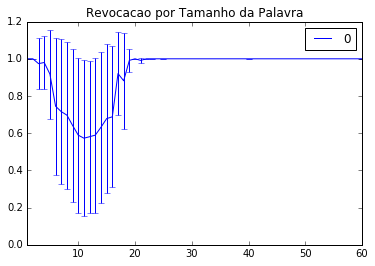

In [28]:
pd.DataFrame(plot).T.plot(y=0, yerr=1, title='Revocacao por Tamanho da Palavra')
print("Revocacao = Normal / Não Stemmizado")

Aqui, a revocação foi calculada como a proporção entre o resultado de stemming com o resultado sem stemming, $Rev = Res/Res_{stem}$.

No gráfico de $Rev$ por tamanho da palavra podemos ver que a revocação é perto de 1 para palavras até 3. Conforme as palavras vão aumentando o $Rev$ vai diminuindo até atingir seu mínimo por volta de 11. A partir de 12, passa a aumentar até voltar novamente para 1 para tamanho de palavra maior que 20.

Esse padrão indica que as palavras grandes desse corpus não são stemmizadas pois podem 

## Exercício 2: Expansão de consultas

Crie grupos de equivalência para alguns termos de busca e calcule a diferença em termos de revocação e, possivelmente precisão, na resposta a consultas expandidas e não expandidas. Dica: use tempos verbais, pluralização, sinônimos, etc.

In [45]:
termos = ['industria', 'industrial', 'industrializado', 'industrializacao', 'maquinário']


resultado = set()


print('Documentos encontrados sem Stem:')
for termo in termos:
    try:
        documentos = indice[termo]
    except KeyError:
        pass
    resultado.update(documentos)
    print('{}: {}'.format(termo, len(documentos)))

print('')
print('TOTAL: {}'.format(len(resultado)))

res = resultado

resultado = set()
print('\n\nDocumentos encontrados com Stem:')
for termo in termos:
    try:
        documentos = indice_stem[stemmer.stem(termo)]
    except KeyError:
        pass
    resultado.update(documentos)
    print('{}: {}'.format(termo, len(documentos)))

print('')
print('TOTAL: {}'.format(len(resultado)))
res_stem = resultado

print('REVOCACAO:', len(res) / len(res_stem) *100, '%')
print("Não entendi o que é precisão.")

Documentos encontrados sem Stem:
industria: 3
industrial: 27
industrializado: 27
industrializacao: 27
maquinário: 27

TOTAL: 30


Documentos encontrados com Stem:
industria: 4
industrial: 27
industrializado: 33
industrializacao: 33
maquinário: 33

TOTAL: 64
REVOCACAO: 46.875 %
Não entendi o que é precisão.


## Exercício 3: Verificação ortográfica

Implemente uma expansão de consulta por meio da correção ortográfica. Utilize o corretor ortográfico Pyenchant para fazer as correções.

In [1]:
import enchant

In [2]:
d = enchant.Dict("pt_BR")

#### Vamos implementar uma função que checa as palavras de busca e sugere novas palavras se algo estiver errado

In [13]:
def busca_certa(palavra):
    
    if not d.check(palavra):
        
        print('Você quis dizer: ')
        for p in d.suggest(palavra)[:5]:
            print('-', p)

In [14]:
busca_certa('ndustria')

Você quis dizer: 
- industria
- nêustria
- industriária
- industriosa
- industrioso


## Exercício 4: Consultas por frases

Implemente um indice invertido que permita consulta por frases, conforme definido na aula 2.

In [49]:
def busca_frase(frase, indice, distancia = 1, ordem_mantida = True, remove_stopwords = True,):
    
    ''' 
    AUTOR: Thiago Trabach
    
    OBJETIVO:
    Buscar uma frase, exata ou não, dentro dentro de uma coleção de documentos
    
    INPUTS:
        frase: frase que será buscada.
        indice: indice invertido onde será buscado
        distancia: distancia máxima entre os termos da frase.
        ordem_mantida: se a ordem dos termos devem ser mantidas ou se é aceito permutações dos termos
           OBS: Utilizar distancia = 1 e ordem_mantida = True para buscar a frase exata
        remove_stopwords: remove stopwords e pontuanções do termo buscado.
            OBS: esse parâmetro deverá ser mantido em True visto que o indíce não recebe stopwords nem pontuação
        
    OUTPUTS:
        1) Indice do documento e indice das palvras buscadas dentro do documento
    '''
    

    ######
    ##NORMALIZA DOS DADOS
    
    #quebra o termo de busca
    if remove_stopwords:
        termo_tokenizado = [token.lower()  for token in WordPunctTokenizer().tokenize(frase) if token not in swu]
    else:
        termo_tokenizado =[token.lower()  for token in WordPunctTokenizer().tokenize(frase)]

    
    ######
    ##TRATAMENTO DE ERROS
    
    #Comprimento da frase tokeniza menor que 2
    if len(termo_tokenizado) < 2: 
        operadores_logicos = termo_tokenizado[1:len(termo_tokenizado):2]
        operadores_logicos = set([operador.lower () for operador in operadores_logicos])

        if len(operadores_logicos - set(['and', 'or', 'not'])) > 0:
            sys.exit('Falta(m) operador(es) logíco(s) entre os termos pesquisados')

        
    ######
    ##CONSULTA OS DOCUMENTOS EM COMUM

    #encontra o vetor de resultados. Cada elemento da lista é o resultado da consulta pora um termo tokenizado
    vetor_documentos = []

    for termo in termo_tokenizado:
        vetor_documentos.append(indice[termo].keys())


    #encontra o documentos que tem em comum para todos os termos
    documentos_comum = set(vetor_documentos[0])

    for documentos in vetor_documentos:
        documentos_comum.intersection_update(set(documentos))

        
        
    ######
    ##CONSULTA A PROXIMIDADE DOS TERMOS DENTRO DOS DOCUMENTOS
        
    resultado = defaultdict(list)

    #verifica nos documentos em comum se os termos são sequencias
    for documento in documentos_comum:
        vetor_posicoes = []

        for termo in termo_tokenizado:
            vetor_posicoes.append(indice[termo][documento])

        for i in vetor_posicoes[0]:

            for j in vetor_posicoes[1]:

                posições = [i,j]


                if abs(posições[1] - posições[0]) <= distancia:

                    if ordem_mantida:
                        if (posições[1] - posições[0]) > 0:
                            resultado[documento].append([posições[0],posições[1]])

                    else:
                        resultado[documento].append([posições[0],posições[1]])    


                if posições[1] - posições[0] > distancia:
                    break

        
        #caso haja mais de dois termos pesquisados, a iteração segue para os demais termos
        if len(termo_tokenizado) > 2:
            for indice_termo in range(2,len(termo_tokenizado)):
                for indice_lista, lista in enumerate(resultado[documento]):
                    for j in vetor_posicoes[indice_termo]:

                        posições = [lista[-1],j]


                        if abs(posições[1] - posições[0]) <= distancia:

                            if ordem_mantida:
                                if (posições[1] - posições[0]) > 0:
                                    resultado[documento][indice_lista].append(posições[1])

                            else:
                                resultado[documento][indice_lista].append(posições[1])    


                        if posições[1] - posições[0] > distancia:
                            break

    
    
    ######
    ##RESULTADO

    #retira as entradas vazias do resultado
    resultado = {key: value for key, value in resultado.items() if len(value) > 0}
    
    #mantém somente os resultados que contenham todos termos pesquisados
    resultado_filtrado = defaultdict(list)

    for i in resultado.keys():
        for j in resultado[i]:
            if len(j) == len(termo_tokenizado):
                resultado_filtrado[i].append(j)
                

    return resultado_filtrado  

In [72]:
busca_frase('luiz inácio', indice)

defaultdict(list,
            {'-2672507519610056171': [[31, 32]],
             '-4844315106079736070': [[42, 43]],
             '-8168836824864880862': [[24, 25]],
             '4923541632460110576': [[25, 26]],
             '4988797239248753161': [[23, 24]],
             '5738628777116837681': [[33, 34]]})

In [75]:
busca_frase('marta suplicy', indice)

defaultdict(list,
            {'-3562477187949878455': [[11, 12]],
             '-3630235699500809805': [[27, 28]],
             '-5654075775677250254': [[11, 12]],
             '-7788344699786316952': [[11, 12]],
             '3735344861791779019': [[16, 17]],
             '6044210032639350457': [[11, 12]],
             '7433847566801444984': [[11, 12]],
             '7734840251668079370': [[11, 12]],
             '8764857732550013136': [[12, 13]]})

## Exercício 5: Consulta híbrida.

Modifique a solução acima para permitir respostas alternativas caso a frase não retorne resultados. Por exemplo, retornar, documentos que contenham parte da frase, ou uma busca booleana simples combinando as palavras da frase.


Para melhorar a busca vamos criar uma função que desativa a ordem obrigatória e que aumenta a distância possível entre as palavras

In [101]:
def busca_soft(frase, indice):
    
    res = busca_frase(frase, indice)
    
    l_res = len(res)
    
    d = 2
    while (l_res == 0) and (d < 30):
        res = busca_frase(frase, indice, distancia = d)
        l_res = len(res)
        d = d + 1
    
    d = 2
    l_res = 0
    while (l_res == 0) and (d < 30):
        res = busca_frase(frase, indice, distancia = d, ordem_mantida=False)
        l_res = len(res)
        d = d + 1
    
    
    return(res)

In [102]:
busca_soft('relator eduardo cunha', indice)

defaultdict(list,
            {'4924998282302483866': [[1, 3, 4]],
             '-1884126250309085187': [[1, 3, 4]],
             '5200538794891779765': [[1, 3, 4]],
             '4948327704877527639': [[4, 6, 7]],
             '-4681917268696757934': [[1, 3, 4]],
             '-2726065397219045312': [[3, 5, 6]],
             '3653333955886040623': [[1, 3, 4]],
             '5746368506724605111': [[1, 3, 4]],
             '2712723049435368817': [[1, 3, 4]],
             '-2788871196882273495': [[1, 3, 4]],
             '3364287253975852354': [[1, 3, 4]],
             '6204436362135966332': [[1, 3, 4]],
             '4141806798746256234': [[1, 3, 4]],
             907533705298937132: [[1, 3, 4]],
             '-148243945892712023': [[1, 3, 4]],
             '5929372476653088788': [[1, 3, 4]],
             '5846620720452562565': [[3, 5, 6]],
             '-9088503719584354502': [[3, 5, 6]]})

In [103]:
busca_soft('eduardo relator cunha', indice)

defaultdict(list,
            {'4924998282302483866': [[3, 1, 4]],
             '-1884126250309085187': [[3, 1, 4]],
             '5200538794891779765': [[3, 1, 4]],
             '4948327704877527639': [[6, 4, 7]],
             '-4681917268696757934': [[3, 1, 4]],
             '-2726065397219045312': [[5, 3, 6]],
             '3653333955886040623': [[3, 1, 4]],
             '5746368506724605111': [[3, 1, 4]],
             '2712723049435368817': [[3, 1, 4]],
             '-2788871196882273495': [[3, 1, 4]],
             '3364287253975852354': [[3, 1, 4]],
             '6204436362135966332': [[3, 1, 4]],
             '4141806798746256234': [[3, 1, 4]],
             907533705298937132: [[3, 1, 4]],
             '-148243945892712023': [[3, 1, 4]],
             '5929372476653088788': [[3, 1, 4]],
             '5846620720452562565': [[5, 3, 6]],
             '-9088503719584354502': [[5, 3, 6]]})